<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/AI/FFT000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
import os
from tensorflow.python.client import device_lib
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])
print()
print()
from google.colab import files
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.layers import Layer
import matplotlib.gridspec as gridspec
from keras.models import Sequential
from keras.layers import Dense, Dropout,concatenate,Subtract,Multiply,Average, Concatenate,Reshape, Add, BatchNormalization
from keras.layers import Reshape,Lambda
from keras.layers.core import Activation
from keras.optimizers import SGD, Adam
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D,MaxPooling2D
import keras.losses
from keras.layers.core import Flatten
from keras import backend as K
import numpy as np
import scipy
from PIL import Image
from keras.layers import Input
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
noises = []

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TIPE
Utilise le CPU




Using TensorFlow backend.


In [0]:
# Install latest Tensorflow build
# !pip install -q tf-nightly-2.0-preview
# from tensorflow import summary
# %load_ext notebookµ

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [5]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy /= np.max(imageSortieTensorCopy)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
index = np.arange(0,len(images))
np.random.shuffle(index)
trainingData = [images[i] for i in index[:int(0.6*len(images))]]
evalData = [images[i] for i in index[int(0.6*len(images))-1:]]

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

In [17]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

W0821 08:26:48.011733 140256182065024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# cf https://stackoverflow.com/questions/43784921/how-to-display-custom-images-in-tensorboard-using-keras?noredirect=1#comment85726690_43784921
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    height, width = tensor.shape
    image = Image.fromarray(tensor).convert('RGB')
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    CHANNEL = 1
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=CHANNEL,
                         encoded_image_string=image_string)

## FFT

In [70]:
pip install imageio

255 0 (199, 199, 3) uint8
255 0 (199, 199, 3) uint8
Creation graphique :  1
Creation graphique :  2
Creation graphique :  3
Creation graphique :  5
Creation graphique :  7
Creation graphique :  4
Creation graphique :  6
Creation graphique :  8
Creation graphique :  9
Creation graphique :  10
Creation graphique :  11
Creation graphique :  13
Creation graphique :  15
Creation graphique :  12
Creation graphique :  14
Creation graphique :  16
Creation graphique :  17
Creation graphique :  18
255 0 (199, 199, 3) uint8
255 0 (199, 199, 3) uint8
Creation graphique :  19
Creation graphique :  20
Creation graphique :  21
Creation graphique :  23
Creation graphique :  25
Creation graphique :  22
Creation graphique :  24
Creation graphique :  26
Creation graphique :  27
Creation graphique :  28
Creation graphique :  29
Creation graphique :  31
Creation graphique :  33
Creation graphique :  30
Creation graphique :  32
Creation graphique :  34
Creation graphique :  35
Creation graphique :  36
255 0

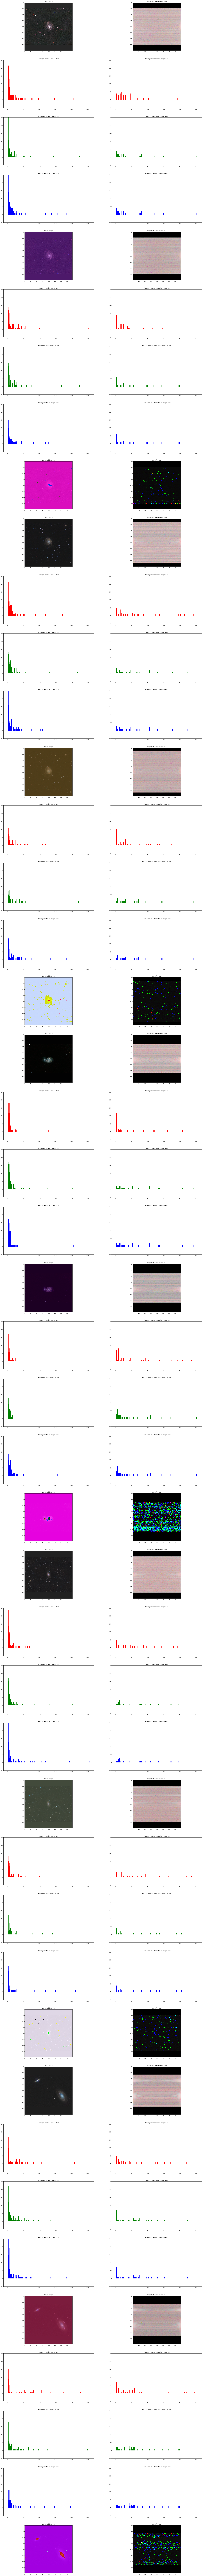

In [101]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
num_samples = 5
fig = plt.figure(figsize=(30,80*num_samples))
index = 1
path_list = []
def show_img(img,name,n_lines,n_cols,fig,gpe_index):
    global index
    ax = fig.add_subplot(n_lines,n_cols,index)
    print("Creation graphique : ",index)
    ax.imshow(img)
    ax.set_title(name)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    name = "FFT_images/"+str(index)+"_".join(name.strip().split(" "))+"_"+str(gpe_index)+".png"
    fig.savefig(name, bbox_inches=extent)
    path_list.append(name)
    index += 1
    
def hist_color(img_array,name,start_index,n_cols,n_lines,fig,gpe_index,last_hist=False):
    global index
    global path_list
    for rgb in range(3):
        ax = fig.add_subplot(n_lines,n_cols,rgb*n_cols+start_index)
        print("Creation graphique : ",rgb*n_cols+start_index)
        color = ["Red","Green","Blue"]
        title = "Histogram "+name+" "+color[rgb]
        hist_for_color(img_array,rgb,ax,color[rgb],title)
        ax.set_title("Histogram "+name+" "+color[rgb])
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        name_final = "FFT_images/"+str(rgb*n_cols+start_index)+"_".join(title.strip().split(" "))+"_"+str(gpe_index)+".png"
        path_list.append(name_final)
        fig.savefig(name_final, bbox_inches=extent)
    if last_hist == True:
        index = 2*n_cols+start_index + 1
    else:
        index += 1
        
def hist_for_color(img_array,color_index,ax,color,name):
    img = img_array.astype(np.uint8 if np.max(img_array) < 1+10**-3 else np.float32)
    hist,bins = np.histogram(img[:,:,color_index] ,256,[0,1 if np.max(img) < 1+10**-3 else 256])
    ax.set_ylim((-5,25))
    ax.hist(hist,bins,color=color)
    ax.set_title(name)

def to_fft(img):
    fft_cplx = np.fft.fft2(img)
    fft = 20*np.log(np.abs(fft_cplx)+10**-5*np.ones(img.shape))
    fft = fft + np.abs(np.min(fft))*np.ones(fft.shape)
    fft = fft / (np.max(fft)*np.ones(fft.shape))*(255*np.ones(fft.shape))
    fft_uint8 = to_uint8_array(fft)
    print(np.max(fft_uint8),np.min(fft_uint8),fft_uint8.shape,fft_uint8.dtype)
    return fft_uint8

def to_img(fft_cplx):
    return to_uint8_array(np.fft.ifft2(fft_cplx))

def to_uint8_array(array):
    return array.astype(np.uint8)
    
for i in range(num_samples):
    image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
    image,imageBruitee = np.array(image[0,:,:,:]*255,dtype=np.uint8),np.array(imageBruitee[0,:,:,:]*255,dtype=np.uint8)
    image_float,imageBruitee_float = np.array(image,dtype=np.float32),np.array(imageBruitee,dtype=np.float32)
    
    image_magnitude_spectrum,imageBruitee_magnitude_spectrum = to_fft(image_float),to_fft(imageBruitee_float)
    n_ligne_gpe = 9
    n_lines = n_ligne_gpe*num_samples
    n_cols = 2
    tot_group_index = n_cols*n_ligne_gpe

    show_img(image,'Clean Image',n_lines,n_cols,fig,i)
    show_img(image_magnitude_spectrum,'Magnitude Spectrum Image',n_lines,n_cols,fig,i)
    
    hist_color(image,name="Clean Image",start_index=index,n_cols=n_cols,n_lines=n_lines,fig=fig,gpe_index=i)
    hist_color(image_magnitude_spectrum,name="Spectrum Image",start_index=index,n_cols=n_cols,n_lines=n_lines,fig=fig,gpe_index=i,last_hist=True)

    show_img(imageBruitee,'Noise Image',n_lines,n_cols,fig,i)
    show_img(imageBruitee_magnitude_spectrum,'Magnitude Spectrum Noise',n_lines,n_cols,fig,i)
    
    hist_color(imageBruitee,name="Noise Image",start_index=index,n_cols=n_cols,n_lines=n_lines,fig=fig,gpe_index=i)
    hist_color(imageBruitee_magnitude_spectrum,name="Spectrum Noise Image",start_index=index,n_cols=n_cols,n_lines=n_lines,fig=fig,gpe_index=i,last_hist=True)

    show_img(np.abs(image-imageBruitee),'Image Difference',n_lines,n_cols,fig,i)
    show_img(np.abs(image_magnitude_spectrum-imageBruitee_magnitude_spectrum),'FFT Difference',n_lines,n_cols,fig,i)
    
plt.show()

In [102]:
for path in path_list:
    print(path)

FFT_images/1Clean_Image_0.png
FFT_images/2Magnitude_Spectrum_Image_0.png
FFT_images/3Histogram_Clean_Image_Red_0.png
FFT_images/5Histogram_Clean_Image_Green_0.png
FFT_images/7Histogram_Clean_Image_Blue_0.png
FFT_images/4Histogram_Spectrum_Image_Red_0.png
FFT_images/6Histogram_Spectrum_Image_Green_0.png
FFT_images/8Histogram_Spectrum_Image_Blue_0.png
FFT_images/9Noise_Image_0.png
FFT_images/10Magnitude_Spectrum_Noise_0.png
FFT_images/11Histogram_Noise_Image_Red_0.png
FFT_images/13Histogram_Noise_Image_Green_0.png
FFT_images/15Histogram_Noise_Image_Blue_0.png
FFT_images/12Histogram_Spectrum_Noise_Image_Red_0.png
FFT_images/14Histogram_Spectrum_Noise_Image_Green_0.png
FFT_images/16Histogram_Spectrum_Noise_Image_Blue_0.png
FFT_images/17Image_Difference_0.png
FFT_images/18FFT_Difference_0.png
FFT_images/19Clean_Image_1.png
FFT_images/20Magnitude_Spectrum_Image_1.png
FFT_images/21Histogram_Clean_Image_Red_1.png
FFT_images/23Histogram_Clean_Image_Green_1.png
FFT_images/25Histogram_Clean_Image

In [104]:
couples = [["Clean_Image","Noise_Image"],['Magnitude_Spectrum_Image',"Magnitude_Spectrum_Noise"],["Histogram_Clean_Image_Red","Histogram_Noise_Image_Red"],["Histogram_Clean_Image_Green","Histogram_Noise_Image_Green"],["Histogram_Clean_Image_Blue","Histogram_Noise_Image_Blue"]]
def appartient_groupe(path,index_groupe,couples=couples):
    for text in couples[index_groupe]:
        if text in path:
            return True
    return False
Lgif = []
for i in range(5):
    for index_groupe in range(len(couples)):
        Lgif.append([])
        for choix in couples[index_groupe]:
            for elem in path_list:
                if choix in elem and elem[elem.index(choix)+len(choix)+1] == str(index_groupe):
                    print(elem)
                    print(elem[elem.index(choix)+len(choix)+1])
                    Lgif[-1] += [elem]
print(Lgif)
import imageio
def save_gif(filenames,path_to_save):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(path_to_save, images, fps=0.7)
for i,group_gif in enumerate(Lgif):
    save_gif(group_gif,"FFT_images/FFT_histogram_"+str(i)+".gif")

FFT_images/1Clean_Image_0.png
0
FFT_images/9Noise_Image_0.png
0
FFT_images/20Magnitude_Spectrum_Image_1.png
1
FFT_images/28Magnitude_Spectrum_Noise_1.png
1
FFT_images/39Histogram_Clean_Image_Red_2.png
2
FFT_images/47Histogram_Noise_Image_Red_2.png
2
FFT_images/59Histogram_Clean_Image_Green_3.png
3
FFT_images/67Histogram_Noise_Image_Green_3.png
3
FFT_images/79Histogram_Clean_Image_Blue_4.png
4
FFT_images/87Histogram_Noise_Image_Blue_4.png
4
FFT_images/1Clean_Image_0.png
0
FFT_images/9Noise_Image_0.png
0
FFT_images/20Magnitude_Spectrum_Image_1.png
1
FFT_images/28Magnitude_Spectrum_Noise_1.png
1
FFT_images/39Histogram_Clean_Image_Red_2.png
2
FFT_images/47Histogram_Noise_Image_Red_2.png
2
FFT_images/59Histogram_Clean_Image_Green_3.png
3
FFT_images/67Histogram_Noise_Image_Green_3.png
3
FFT_images/79Histogram_Clean_Image_Blue_4.png
4
FFT_images/87Histogram_Noise_Image_Blue_4.png
4
FFT_images/1Clean_Image_0.png
0
FFT_images/9Noise_Image_0.png
0
FFT_images/20Magnitude_Spectrum_Image_1.png
1
FF